In [1]:
# import packages
import pandas as pd
import numpy as np
import time
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from tensorflow.keras.layers import Input, Dense

%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf

from tensorflow.keras import models, layers, activations
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers, losses


RANDOM_SEED = 50
TEST_PCT = 0.2 


rcParams['figure.figsize'] = 10, 6.5
LABELS = ["Normal","Fraud"]
col_list = ["cerulean","scarlet"]# https://xkcd.com/color/rgb/
sns.set(style='white', font_scale=1.75, palette=sns.xkcd_palette(col_list))

In [2]:
df = pd.read_csv("creditcard_transactions.csv") 
df.head(n=5) 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.shape 

(284807, 31)

In [4]:
pd.value_counts(df['Class'], sort = True) #class comparison 0=Normal 1=Fraud

0    284315
1       492
Name: Class, dtype: int64

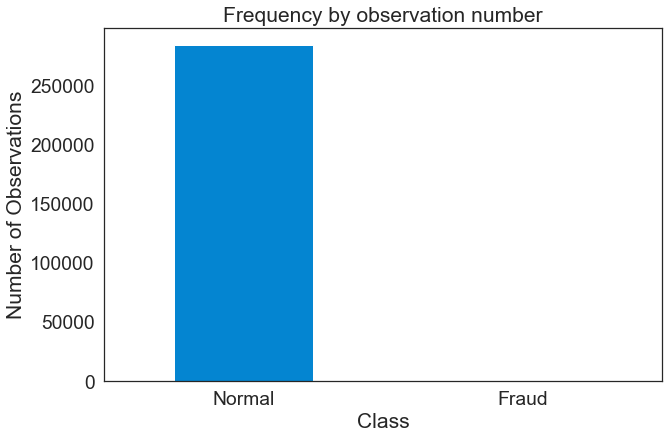

In [10]:
#if you don't have an intuitive sense of how imbalanced these two classes are, let's go visual
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS)
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

In [11]:
normal_df = df[df.Class == 0] 
fraud_df = df[df.Class == 1]

In [12]:
normal_df.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [13]:
fraud_df.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

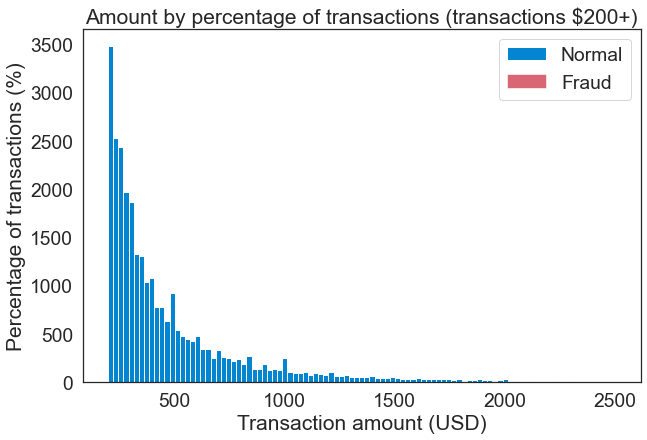

In [14]:
#plot of high value transactions
bins = np.linspace(200, 2500, 100)
plt.hist(normal_df.Amount, bins, alpha=1, label='Normal')
plt.hist(fraud_df.Amount, bins, alpha=0.6, label='Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions (transactions \$200+)")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)");
plt.show()

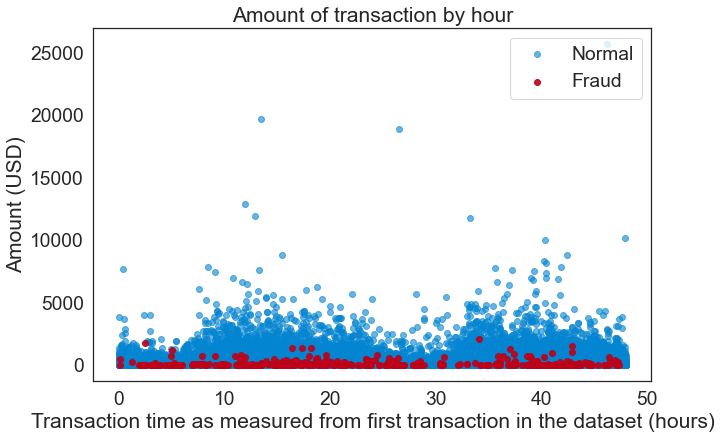

In [15]:
plt.scatter((normal_df.Time/(60*60)), normal_df.Amount, alpha=0.6, label='Normal')
plt.scatter((fraud_df.Time/(60*60)), fraud_df.Amount, alpha=0.9, label='Fraud')
plt.title("Amount of transaction by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel('Amount (USD)')
plt.legend(loc='upper right')
plt.show()

In [16]:
#data = df.drop(['Time'], axis=1) #if you think the var is unimportant
df_norm = df
df_norm['Time'] = StandardScaler().fit_transform(df_norm['Time'].values.reshape(-1, 1))
df_norm['Amount'] = StandardScaler().fit_transform(df_norm['Amount'].values.reshape(-1, 1))

In [17]:
train_x, test_x = train_test_split(df_norm, test_size=TEST_PCT, random_state=RANDOM_SEED)
train_x = train_x[train_x.Class == 0] #where normal transactions
train_x = train_x.drop(['Class'], axis=1) #drop the class column


test_y = test_x['Class'] #save the class column for the test set
test_x = test_x.drop(['Class'], axis=1) #drop the class column

train_x = train_x.values #transform to ndarray
test_x = test_x.values

In [18]:
train_x.shape

(227441, 30)

In [19]:
nb_epoch = 30
batch_size = 32
input_dim = train_x.shape[1] #num of columns, 30

encoder = tf.keras.models.Sequential(name='encoder')
encoder.add(layer=layers.Dense(units=30, activation=activations.swish, input_shape=[input_dim]))
encoder.add(layer=layers.Dense(units=20, activation=activations.swish))
encoder.add(layer=layers.Dense(units=14, activation=activations.swish))

decoder = tf.keras.models.Sequential(name='decoder')
decoder.add(layer=layers.Dense(units=14, activation=activations.swish, input_shape=[14]))
decoder.add(layer=layers.Dense(units=20, activation=activations.swish))
decoder.add(layer=layers.Dense(units=input_dim, activation=activations.linear))

autoencoder = tf.keras.models.Sequential([encoder, decoder])

In [20]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 14)                1844      
_________________________________________________________________
decoder (Sequential)         (None, 30)                1140      
Total params: 2,984
Trainable params: 2,984
Non-trainable params: 0
_________________________________________________________________


In [19]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

start = time.time()
history = autoencoder.fit(train_x, train_x,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_x, test_x),
                    verbose=1)
end = time.time()
print("Time elapsed:",end-start,"s")
                  

Epoch 1/30
7108/7108 [==============================] - 9s 1ms/step - loss: 0.4666 - accuracy: 0.5555 - val_loss: 0.2215 - val_accuracy: 0.7362
Epoch 2/30
7108/7108 [==============================] - 8s 1ms/step - loss: 0.1801 - accuracy: 0.7465 - val_loss: 0.1770 - val_accuracy: 0.7841
Epoch 3/30
7108/7108 [==============================] - 8s 1ms/step - loss: 0.1477 - accuracy: 0.7815 - val_loss: 0.1627 - val_accuracy: 0.7998
Epoch 4/30
7108/7108 [==============================] - 9s 1ms/step - loss: 0.1317 - accuracy: 0.7946 - val_loss: 0.1585 - val_accuracy: 0.8054
Epoch 5/30
7108/7108 [==============================] - 9s 1ms/step - loss: 0.1294 - accuracy: 0.8011 - val_loss: 0.1586 - val_accuracy: 0.7968
Epoch 6/30
7108/7108 [==============================] - 9s 1ms/step - loss: 0.1378 - accuracy: 0.7943 - val_loss: 0.1527 - val_accuracy: 0.7983
Epoch 7/30
7108/7108 [==============================] - 10s 1ms/step - loss: 0.1204 - accuracy: 0.8029 - val_loss: 0.1486 - val_accuracy

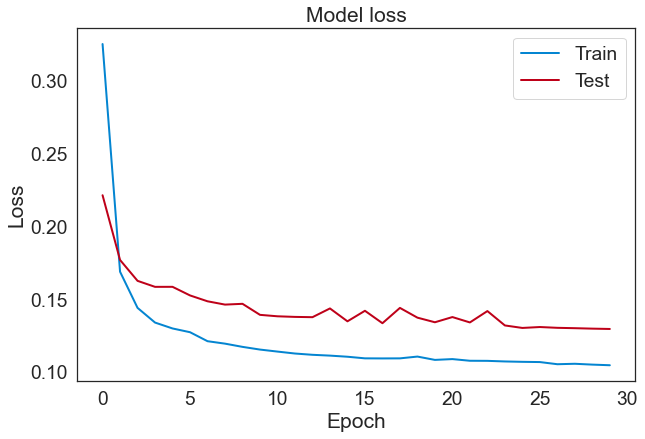

In [20]:
plt.plot(history.history['loss'], linewidth=2, label='Train')
plt.plot(history.history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [21]:
test_x_predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
error_df.describe()

,Reconstruction_error,True_class
count,56962.000000,56962.000000
mean,0.129594,0.001545
std,1.147396,0.039275
min,0.003844,0.000000
25%,0.038149,0.000000
50%,0.060484,0.000000
75%,0.103137,0.000000
max,64.532797,1.000000


In [27]:
print(np.shape(test_x))

(56962, 30)


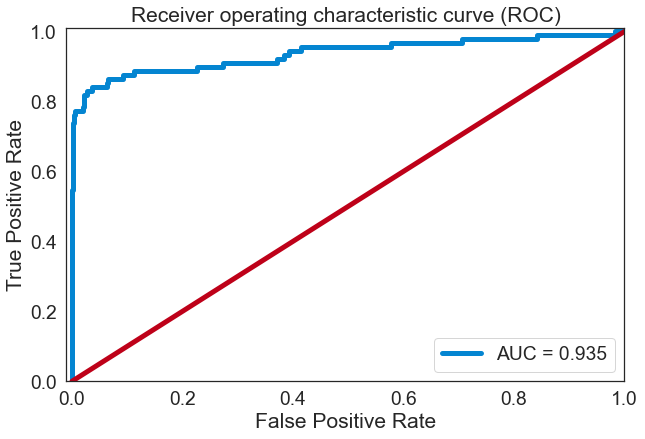

In [22]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

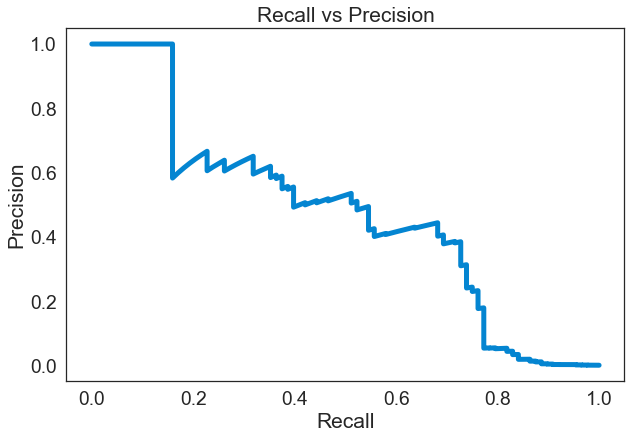

In [23]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

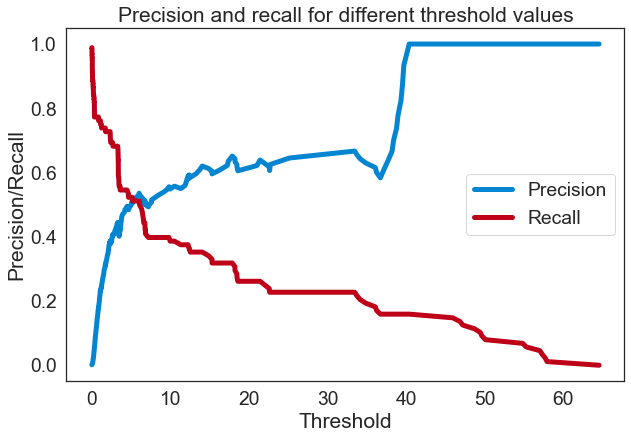

In [24]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [ ]:
normal_df = normal_df.drop(['Class'], axis=1)
fraud_df = fraud_df.drop(['Class'], axis=1)

normal_samples = normal_df.values
fraud_samples = fraud_df.values

In [40]:
normal_predictions = autoencoder.predict(normal_samples)
fraud_predictions = autoencoder.predict(fraud_samples)

normal_predictions = normal_predictions[0:len(fraud_predictions)] #Keeping same number of samples for comparison purposes

In [41]:
mse_normal = np.mean(np.power(normal_samples[0:len(fraud_predictions)] - normal_predictions, 2), axis=1)
normal_error_df = pd.DataFrame({'Reconstruction_error': mse_normal})
normal_error_df.describe()

,Reconstruction_error
count,492.000000
mean,2499.365687
std,15401.604586
min,0.248382
25%,273.110160
50%,1171.719141
75%,2511.460154
max,336088.180884


In [42]:
mse_fraud = np.mean(np.power(fraud_samples - fraud_predictions, 2), axis=1)
fraud_error_df = pd.DataFrame({'Reconstruction_error': mse_fraud})
fraud_error_df.describe()

,Reconstruction_error
count,4.920000e+02
mean,2.794190e+08
std,2.710557e+08
min,5.150197e+03
25%,5.398450e+07
50%,1.812405e+08
75%,5.239259e+08
max,9.209785e+08


In [44]:
relative_mse = mse_fraud/mse_normal
print(np.mean(relative_mse))

216868.24542068358
